<a href="https://colab.research.google.com/github/esterna25/OPetCNNModel/blob/main/OpetModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs and Cats Breeds Classification
> Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/

## About Dataset

<b>Overview</b>

<p>The Dataset have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.</p>


### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import callbacks
from tensorflow.keras.utils import plot_model

In [2]:
import seaborn as sns

In [3]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Datasets Version:", tfds.__version__)

• Using TensorFlow Version: 2.15.0
• Using TensorFlow Datasets Version: 4.9.4


### Import Dataset

#### Load and Split the raw image data
Dividing the train split of this dataset into (train, val, test) with 90, 5, 5 of the data respectively

In [4]:
# make directory data
# import os


# os.makedirs('data', exist_ok=True)

In [5]:
(train_raw, val_raw, test_raw), ds_info = tfds.load (
                                          name='oxford_iiit_pet',
                                          split=['train', 'test[90%:]', 'test[:90%]'],
                                          shuffle_files=True,
                                          as_supervised=True,
                                          with_info=True,
                                          data_dir='data'
                                        )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling data/oxford_iiit_pet/3.2.0.incompleteY8E4XX/oxford_iiit_pet-train.tfrecord*...:   0%|          | 0/3…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling data/oxford_iiit_pet/3.2.0.incompleteY8E4XX/oxford_iiit_pet-test.tfrecord*...:   0%|          | 0/36…

Dataset oxford_iiit_pet downloaded and prepared to data/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpnjmd5c8ctfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

### Understanding The Dataset

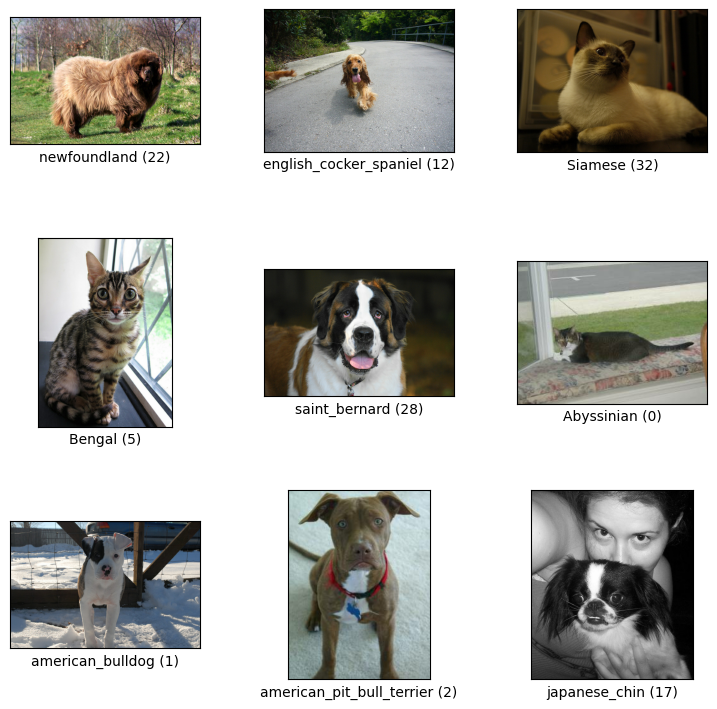

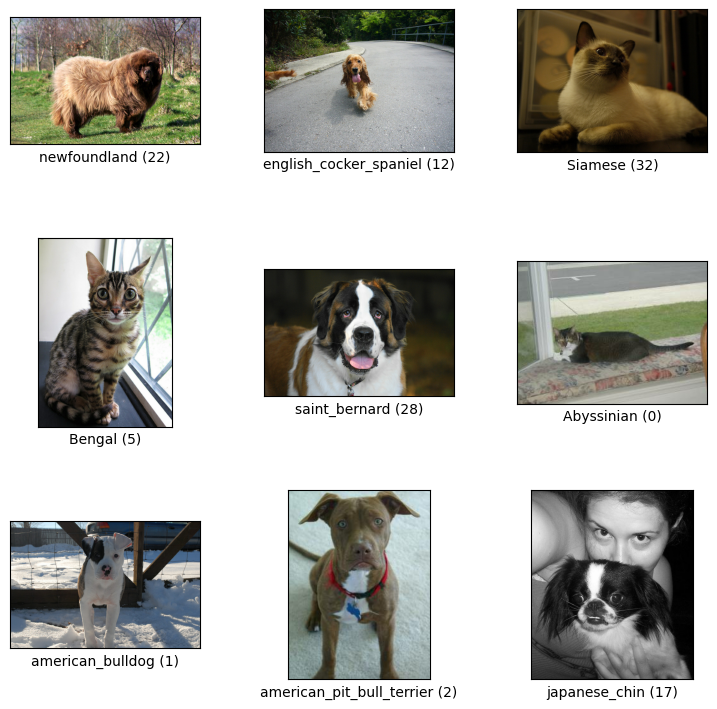

In [7]:
# Show some examples
tfds.show_examples(train_raw, ds_info, image_key='image', label_key='label', rows=3, cols=3)

In [8]:
# Show number of classes
num_classes = ds_info.features['label'].num_classes
print(f"Jumlah Class : {num_classes}")

Jumlah Class : 37


In [9]:
# Show class names
name_classes = ds_info.features['label'].names
print(name_classes)

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [10]:
label = ds_info.features['label']
species = ds_info.features['species'].names


In [11]:
# Show number of examples
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print(f"Jumlah Data Training: {num_train_examples}")
print(f"Jumlah Data Validation: {num_val_examples}")
print(f"Jumlah Data Testing: {num_test_examples}")

Jumlah Data Training: 3680
Jumlah Data Validation: 367
Jumlah Data Testing: 3302


In [12]:
# Get the label from the dataset
get_label_name = ds_info.features['label'].int2str

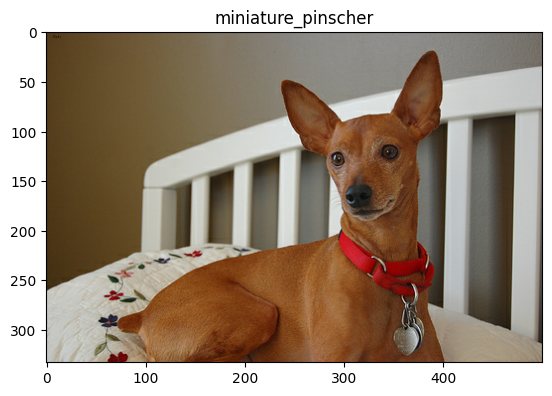

In [13]:
# Show the image and the label
def view_single_image(ds):
    image, label = next(iter(ds))
    plt.imshow(image)
    _ = plt.title(get_label_name(label))


view_single_image(train_raw)

### Data Preparation

#### Image Resizing

In [14]:
IMG_SIZE = 299

train_ds = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
test_ds = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

#### Label one-hot encoding

In [15]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [16]:
# map the one_hot_encode function to the train, val, and test datasets
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [17]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(factor=(-0.025, 0.025)),
     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.RandomContrast(factor=0.1),
     ])

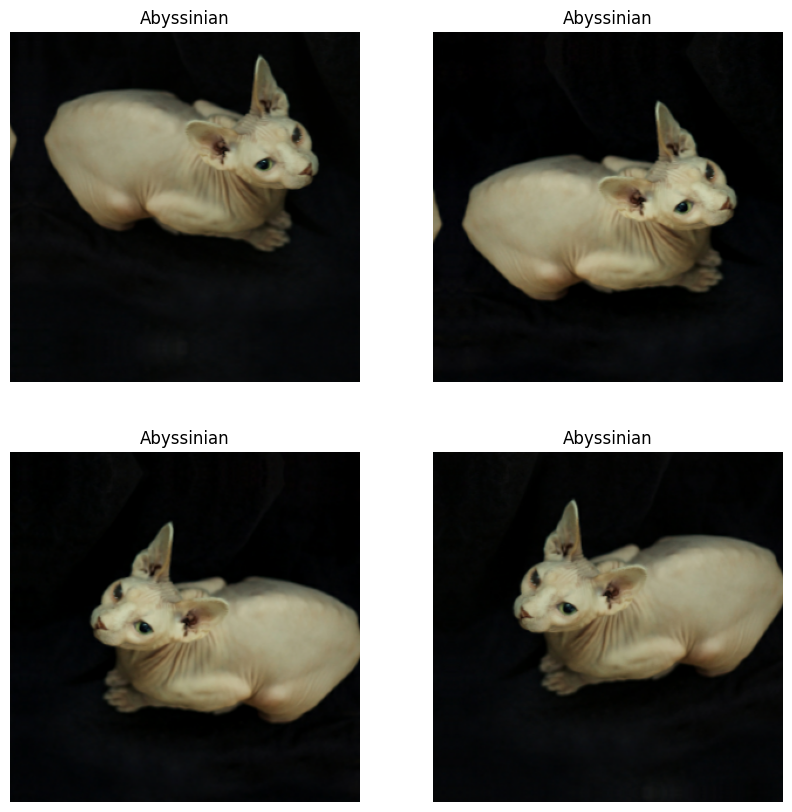

In [18]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

In [19]:
BATCH_SIZE = 32

In [20]:
train_ds = train_ds.batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [21]:
def getModel(dropout=0.25):
  # setup base model
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

  # Freeze  pre-trained weight of the base mode
  base_model.trainable = False

  # input layers
  inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = data_augmentation(inputs)

  # pass inputs to a process layer
  x = tf.keras.applications.inception_v3.preprocess_input(x)
  x = base_model(x, training=False)

  # Rebuild top layers
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  outputs = tf.keras.layers.Dense(37, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  # Display model summary
  model.summary()

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[keras.metrics.CategoricalAccuracy()])

  return model


#### Model Training

In [22]:
# prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

In [23]:
model = getModel()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                              

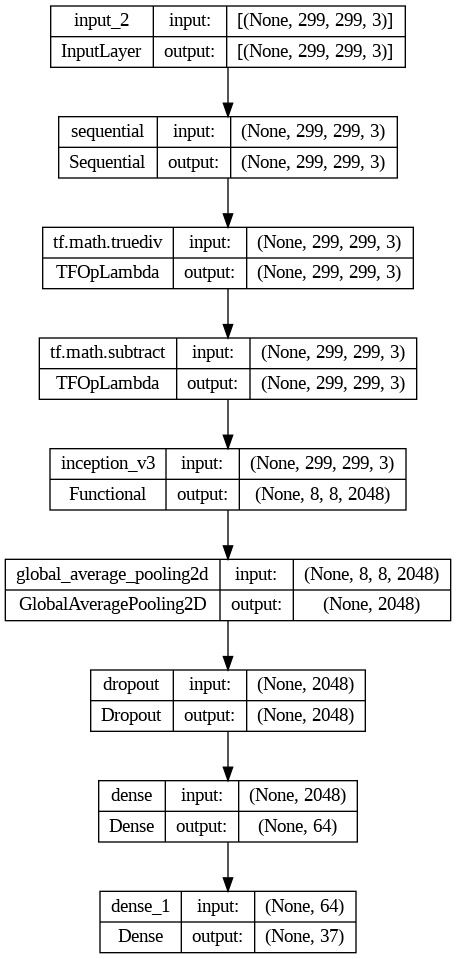

In [24]:
plot_model(model, show_shapes=True)

In [25]:
# Fit Model
history = model.fit(
    train_ds,
    epochs = 25,
    validation_data=val_ds,
    verbose=1,
    callbacks = [earlystopping]
)

Epoch 1/25
115/115 [==============================] - 30s 155ms/step - loss: 1.4003 - categorical_accuracy: 0.6462 - val_loss: 0.3867 - val_categorical_accuracy: 0.8892
Epoch 2/25
115/115 [==============================] - 19s 160ms/step - loss: 0.3843 - categorical_accuracy: 0.8886 - val_loss: 0.2798 - val_categorical_accuracy: 0.9233
Epoch 3/25
115/115 [==============================] - 17s 146ms/step - loss: 0.2829 - categorical_accuracy: 0.9098 - val_loss: 0.2588 - val_categorical_accuracy: 0.9176
Epoch 4/25
115/115 [==============================] - 17s 147ms/step - loss: 0.2261 - categorical_accuracy: 0.9272 - val_loss: 0.2590 - val_categorical_accuracy: 0.9091
Epoch 5/25
115/115 [==============================] - 18s 158ms/step - loss: 0.2103 - categorical_accuracy: 0.9321 - val_loss: 0.2437 - val_categorical_accuracy: 0.9261
Epoch 6/25
115/115 [==============================] - 17s 146ms/step - loss: 0.1650 - categorical_accuracy: 0.9467 - val_loss: 0.2518 - val_categorical_acc

#### Plot the accuracy of training and validation sets over epochs

Text(0.5, 1.0, 'Training and validation loss')

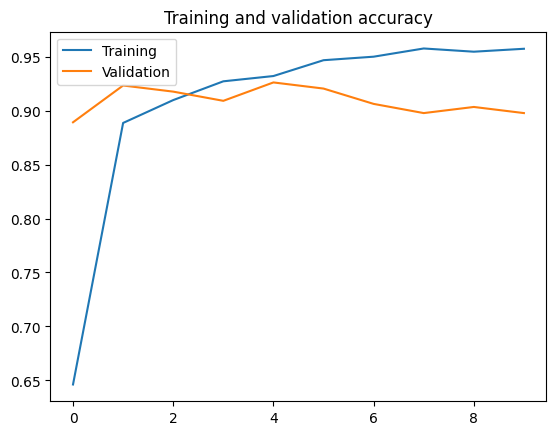

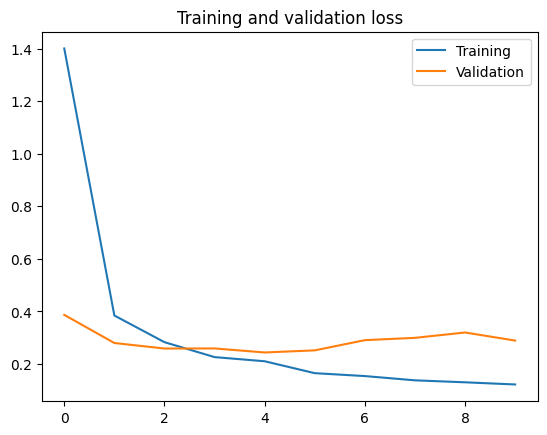

In [26]:
acc      = history.history[     'categorical_accuracy' ]
val_acc  = history.history[ 'val_categorical_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

### Model Evaluation

In [27]:
# Evaluate model
preds = model.predict(test_ds)

103/103 [==============================] - 15s 131ms/step


In [28]:
# Evaluate model on test dataset
result = model.evaluate(test_ds)

103/103 [==============================] - 14s 132ms/step - loss: 0.2837 - categorical_accuracy: 0.9053


In [29]:
# Display result
dict(zip(model.metrics_names, result))

{'loss': 0.2836971879005432, 'categorical_accuracy': 0.905339777469635}

### Finetuned Model

In [30]:
# Unfreeze base model
for layer in model.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [31]:
# Recompile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Set a very low learning rate
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

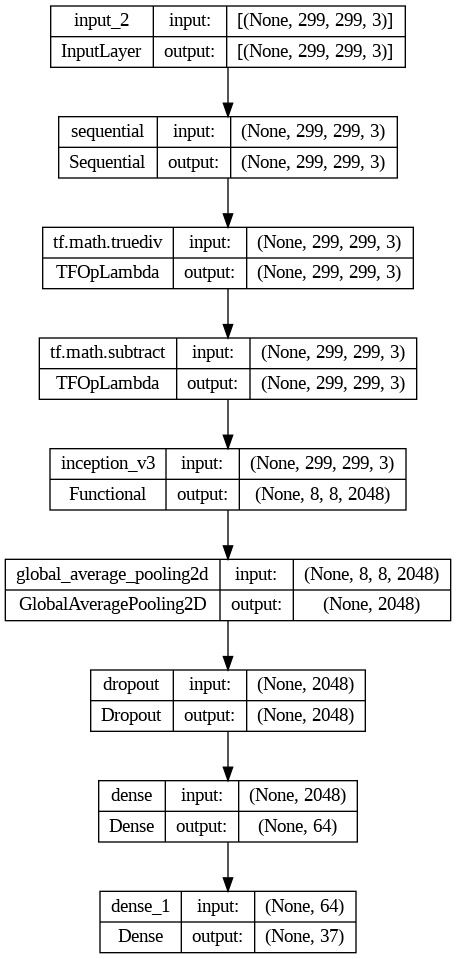

In [32]:
# visualize model
plot_model(model, show_shapes=True)

In [33]:
# Retrain model
EPOCHS = 5

history_2 = model.fit(train_ds,
                      epochs=EPOCHS,
                      validation_data=val_ds,
                      verbose=1,
                      callbacks =[earlystopping])

Epoch 1/5
115/115 [==============================] - 96s 485ms/step - loss: 0.1407 - categorical_accuracy: 0.9497 - val_loss: 0.2620 - val_categorical_accuracy: 0.9176
Epoch 2/5
115/115 [==============================] - 52s 452ms/step - loss: 0.0883 - categorical_accuracy: 0.9693 - val_loss: 0.2738 - val_categorical_accuracy: 0.9205
Epoch 3/5
115/115 [==============================] - 53s 462ms/step - loss: 0.0589 - categorical_accuracy: 0.9804 - val_loss: 0.2554 - val_categorical_accuracy: 0.9233
Epoch 4/5
115/115 [==============================] - 53s 456ms/step - loss: 0.0447 - categorical_accuracy: 0.9845 - val_loss: 0.2985 - val_categorical_accuracy: 0.9176
Epoch 5/5
115/115 [==============================] - 53s 459ms/step - loss: 0.0277 - categorical_accuracy: 0.9916 - val_loss: 0.2875 - val_categorical_accuracy: 0.9205


In [34]:
preds2 = model.predict(test_ds)

103/103 [==============================] - 15s 129ms/step


In [35]:
# Display fine-tuned model result
result_2 = model.evaluate(test_ds)

dict(zip(model.metrics_names, result_2))

103/103 [==============================] - 14s 134ms/step - loss: 0.2952 - categorical_accuracy: 0.9275


{'loss': 0.2952464520931244, 'categorical_accuracy': 0.927487850189209}

In [36]:
# Save model
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Metrics Evaluation

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

In [38]:
# Melakukan prediksi pada data validasi
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)  # Mengambil indeks kelas dengan nilai probabilitas tertinggi

# Mengubah kembali one-hot encoded label menjadi label tunggal
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in val_ds], axis=0)

# Membuat classification report
report = classification_report(y_true, y_pred, target_names=name_classes, output_dict=True)

11/11 [==============================] - 2s 143ms/step


In [39]:
print(report)

{'Abyssinian': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9}, 'american_bulldog': {'precision': 0.5, 'recall': 0.7142857142857143, 'f1-score': 0.588235294117647, 'support': 7}, 'american_pit_bull_terrier': {'precision': 0.8571428571428571, 'recall': 0.4, 'f1-score': 0.5454545454545455, 'support': 15}, 'basset_hound': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1-score': 0.9523809523809523, 'support': 11}, 'beagle': {'precision': 0.9230769230769231, 'recall': 1.0, 'f1-score': 0.9600000000000001, 'support': 12}, 'Bengal': {'precision': 0.7777777777777778, 'recall': 1.0, 'f1-score': 0.8750000000000001, 'support': 7}, 'Birman': {'precision': 0.75, 'recall': 0.8571428571428571, 'f1-score': 0.7999999999999999, 'support': 7}, 'Bombay': {'precision': 1.0, 'recall': 0.7142857142857143, 'f1-score': 0.8333333333333333, 'support': 7}, 'boxer': {'precision': 0.8, 'recall': 1.0, 'f1-score': 0.888888888888889, 'support': 12}, 'British_Shorthair': {'precision': 0.9, 'recall':

In [40]:
# Mendapatkan akurasi dari laporan klasifikasi
accuracy = report['accuracy']
print("Accuracy:", accuracy)

Accuracy: 0.9204545454545454


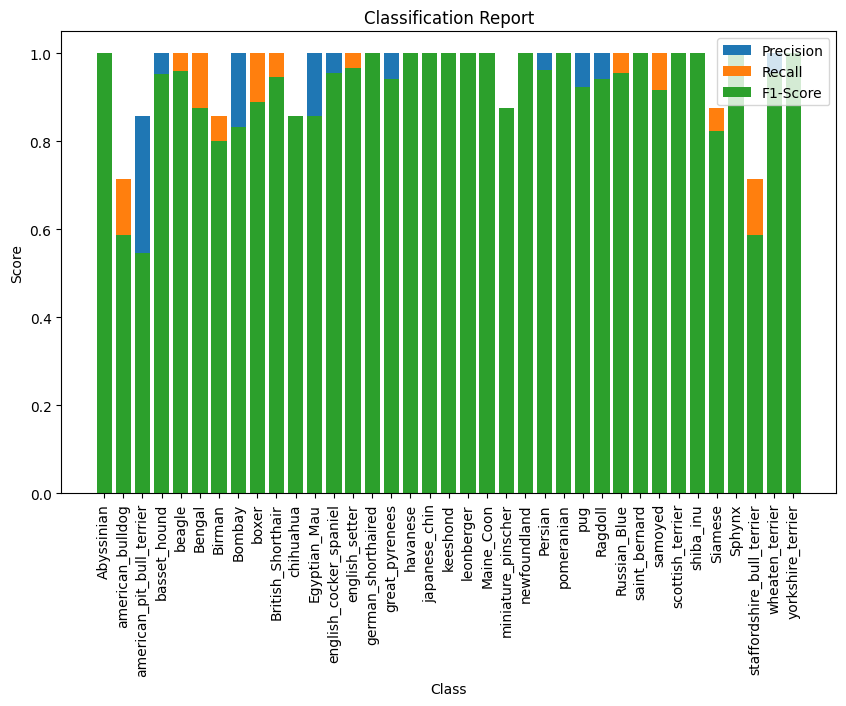

In [41]:
# Mengekstrak nilai precision, recall, dan f1-score
# Mengekstrak nilai precision, recall, dan f1-score
precision = [report[class_name]['precision'] for class_name in name_classes]
recall = [report[class_name]['recall'] for class_name in name_classes]
f1_score = [report[class_name]['f1-score'] for class_name in name_classes]


# Membuat plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(num_classes)
ax.bar(x, precision, label='Precision')
ax.bar(x, recall, label='Recall')
ax.bar(x, f1_score, label='F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(name_classes, rotation=90)
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.legend()
plt.show()

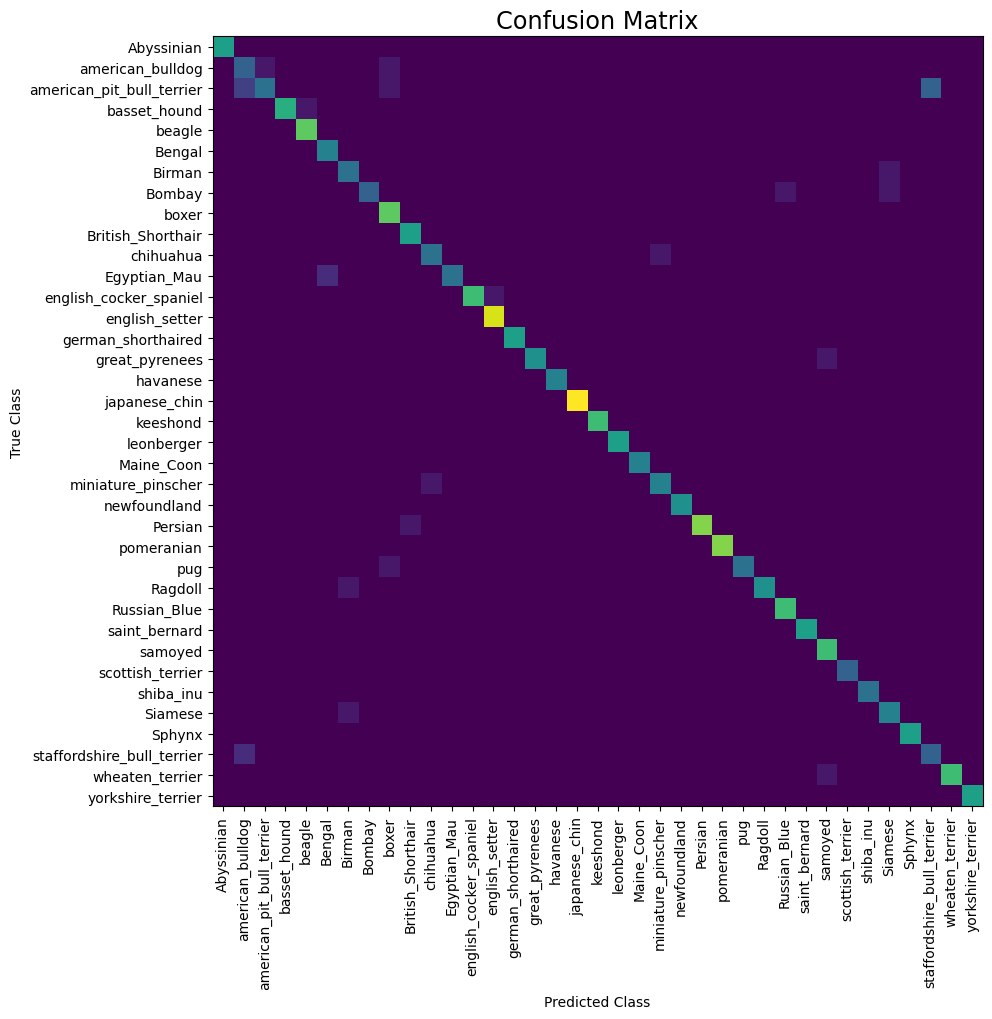

In [42]:
# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots( figsize= (10, 10))

ax.imshow(cm)

ax.set_xticks(range(0, 37))
ax.set_yticks(range(0,37))

ax.set_yticklabels(name_classes)
ax.set_xticklabels(name_classes, rotation='vertical')

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix', size='xx-large')
plt.show()

In [43]:
import pandas as pd


# Create table for metrics evaluation
metrics = pd.DataFrame({'Class': name_classes,
                        'Precision': precision,
                        'Recall': recall,
                        'F1_score': f1_score
                        })


metrics

,Class,Precision,Recall,F1_score
0,Abyssinian,1.000000,1.000000,1.000000
1,american_bulldog,0.500000,0.714286,0.588235
2,american_pit_bull_terrier,0.857143,0.400000,0.545455
3,basset_hound,1.000000,0.909091,0.952381
4,beagle,0.923077,1.000000,0.960000
5,Bengal,0.777778,1.000000,0.875000
6,Birman,0.750000,0.857143,0.800000
7,Bombay,1.000000,0.714286,0.833333
8,boxer,0.800000,1.000000,0.888889
9,British_Shorthair,0.900000,1.000000,0.947368


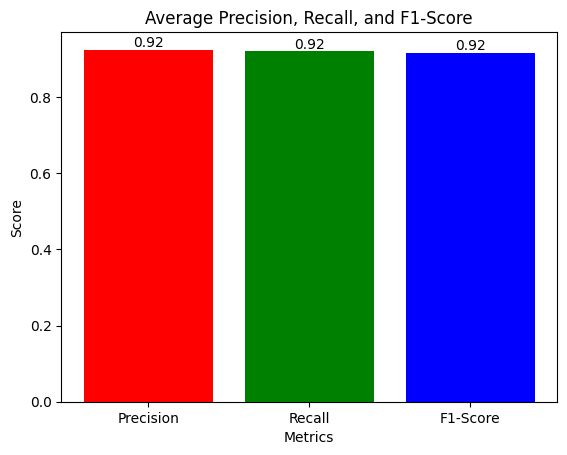

In [47]:
# visualize average precision, recall, and f1-score
# Menghitung rata-rata precision, recall, dan f1-score
avg_precision = sum(precision) / num_classes
avg_recall = sum(recall) / num_classes
avg_f1_score = sum(f1_score) / num_classes

# Menampilkan visualisasi
metrics = ['Precision', 'Recall', 'F1-Score']
values = [avg_precision, avg_recall, avg_f1_score]
colours = ['r', 'g', 'b']

plt.bar(metrics, values, color=colours)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Average Precision, Recall, and F1-Score')

# Menambahkan nilai score pada setiap bar
for i, value in enumerate(values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')


plt.show()

In [51]:
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1Score:", avg_f1_score)
print("Accuracy:", accuracy)

Precision: 0.9248172623172625
Recall: 0.9206232206232204
F1Score: 0.9165967162744397
Accuracy: 0.9204545454545454


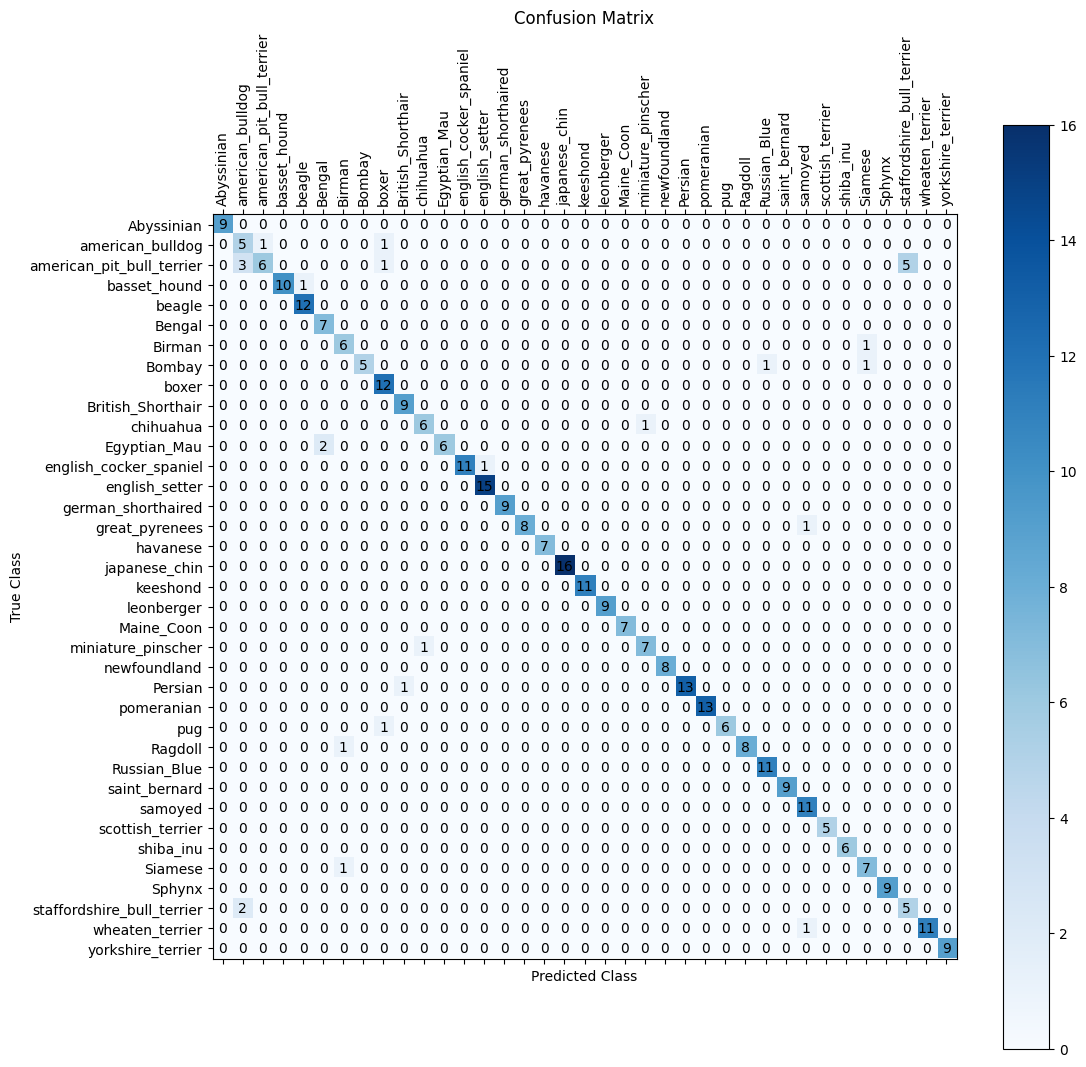

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming cm is the confusion matrix, name_classes is the list of class names
# and y_true, y_pred are the true and predicted labels respectively.

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix if needed
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the confusion matrix
cax = ax.matshow(cm, cmap='Blues')

# Add color bar
fig.colorbar(cax)

# Set labels for axes
ax.set_xticks(np.arange(len(name_classes)))
ax.set_yticks(np.arange(len(name_classes)))
ax.set_xticklabels(name_classes, rotation=90)
ax.set_yticklabels(name_classes)

# Loop over data dimensions and create text annotations
for i in range(len(name_classes)):
    for j in range(len(name_classes)):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='black')

# Set labels and title
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')

# Show plot
plt.show()


In [53]:
y_pred_probs = model.predict(val_ds)

for i in range (5):
  print("Nilai probabilitas untuk sampel", i+1, ":", y_pred_probs[i])

11/11 [==============================] - 3s 184ms/step
Nilai probabilitas untuk sampel 1 : [2.40098758e-04 5.38211282e-07 8.49104964e-09 3.59488217e-10
 1.68623622e-08 9.27748886e-07 4.77385902e-06 7.37009250e-05
 1.13124679e-06 9.94926095e-01 4.09396628e-10 7.86539456e-09
 1.34197194e-07 1.69243553e-08 5.02439207e-06 1.20240887e-10
 9.96398128e-08 3.71399764e-08 1.98199945e-09 4.01502120e-09
 2.54748884e-04 3.35082262e-07 9.54216119e-08 3.15734855e-04
 1.94308321e-08 3.87090998e-10 2.92988215e-03 1.09804259e-03
 1.08077265e-05 5.28935061e-07 5.43199485e-06 1.37197091e-07
 1.68945564e-06 1.28398984e-04 3.05114778e-09 4.48191066e-08
 1.34232084e-06]
Nilai probabilitas untuk sampel 2 : [3.9436874e-11 1.5880766e-09 1.6604021e-10 2.0814809e-08 8.0243606e-10
 4.5965143e-09 2.8659119e-12 3.1952080e-10 4.7681281e-09 3.1540808e-11
 2.9573709e-12 7.3295418e-11 9.6301511e-10 9.6464295e-12 4.4440063e-11
 2.2718941e-11 2.3663762e-09 2.1645825e-09 1.3967734e-09 3.6303680e-10
 9.6553487e-10 3.991373

In [54]:
# Melakukan prediksi pada dataset validasi
y_pred_probs = model.predict(val_ds)

# Mencetak predicted class, correct class, dan probabilitas untuk beberapa sampel pertama
for i, (image, label) in enumerate(val_ds.take(5)):
    # Mendapatkan nilai probabilitas untuk kelas yang diprediksi
    predicted_class_prob = y_pred_probs[i]
    # Mengambil indeks kelas dengan nilai probabilitas tertinggi sebagai kelas yang diprediksi
    predicted_class = np.argmax(predicted_class_prob)

    # Mengambil kelas yang benar dari label
    correct_class = np.argmax(label)

    # Mencetak predicted class, correct class, dan probabilitas
    print("Sample", i+1)
    print("Predicted Class:", predicted_class)
    print("Correct Class:", correct_class)
    print("Probability:", predicted_class_prob)
    print()


11/11 [==============================] - 1s 127ms/step
Sample 1
Predicted Class: 9
Correct Class: 9
Probability: [2.40098758e-04 5.38211282e-07 8.49104964e-09 3.59488217e-10
 1.68623622e-08 9.27748886e-07 4.77385902e-06 7.37009250e-05
 1.13124679e-06 9.94926095e-01 4.09396628e-10 7.86539456e-09
 1.34197194e-07 1.69243553e-08 5.02439207e-06 1.20240887e-10
 9.96398128e-08 3.71399764e-08 1.98199945e-09 4.01502120e-09
 2.54748884e-04 3.35082262e-07 9.54216119e-08 3.15734855e-04
 1.94308321e-08 3.87090998e-10 2.92988215e-03 1.09804259e-03
 1.08077265e-05 5.28935061e-07 5.43199485e-06 1.37197091e-07
 1.68945564e-06 1.28398984e-04 3.05114778e-09 4.48191066e-08
 1.34232084e-06]

Sample 2
Predicted Class: 30
Correct Class: 23
Probability: [3.9436874e-11 1.5880766e-09 1.6604021e-10 2.0814809e-08 8.0243606e-10
 4.5965143e-09 2.8659119e-12 3.1952080e-10 4.7681281e-09 3.1540808e-11
 2.9573709e-12 7.3295418e-11 9.6301511e-10 9.6464295e-12 4.4440063e-11
 2.2718941e-11 2.3663762e-09 2.1645825e-09 1.39

### Converted Model to TFLite

In [55]:
model = tf.keras.models.load_model('my_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


# Save the TFLite model to a file
with open('OPet_model.tflite', 'wb') as f:
    f.write(tflite_model)

with open('labels.txt', 'w') as f:
    f.write('\n'.join(name_classes) + '\n')

